# Bayesian Exploration with NaNs

As violations of constraints can lead to invalid values of the objective, the evaluate function may simply return NaNs. We demonstrate below how we can still perform Bayesian Exploration in that case.

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import torch
import yaml
from copy import deepcopy
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

vocs = deepcopy(tnk_vocs)

# can only explore one objective
del vocs.objectives["y2"]

In [2]:
# modify the evaluate function to return NaNs if constraints are violated
def evaluate(input_dict):
    output_dict = evaluate_TNK(input_dict)
    del output_dict["y2"]
    for c in vocs.constraints.keys():
        if vocs.constraints[c][0].upper() == "GREATER_THAN" and output_dict[c] <= vocs.constraints[c][1]:
            output_dict["y1"] = torch.nan
        elif vocs.constraints[c][0].upper() == "LESS_THAN" and output_dict[c] >= vocs.constraints[c][1]:
            output_dict["y1"] = torch.nan
    return output_dict

In [3]:
generator = BayesianExplorationGenerator(vocs=vocs)
generator.max_travel_distances = [0.25, 0.25]
generator.n_monte_carlo_samples = NUM_MC_SAMPLES
generator.numerical_optimizer.n_restarts = NUM_RESTARTS

evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X


            Xopt
________________________________
Version: 0+untagged.1.g31da5da
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: null, max_evaluations: null}
generator:
  name: bayesian_exploration
  model: null
  turbo_controller: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 2000}
  max_travel_distances: [0.25, 0.25]
  n_monte_carlo_samples: 128
evaluator:
  function: __main__.evaluate
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE}
  constants: {a: dummy_constant}
  observables: []


## Run exploration
We start with evaluating 2 points that we know satisfy the constraints. We then run
30 exploration steps.

In [4]:
X.evaluate_data(pd.DataFrame({"x1": [1.0, 0.75], "x2": [0.7, 0.95]}))

,x1,x2,y1,c1,c2,some_array,xopt_runtime,xopt_error
1,1.00,0.70,1.00,0.584045,0.290,"[1, 2, 3]",0.000066,False
2,0.75,0.95,0.75,0.494833,0.265,"[1, 2, 3]",0.000013,False


In [5]:
N_STEPS = 1 if SMOKE_TEST else 30
for i in range(N_STEPS):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29


In [6]:
# view the data
X.data

,x1,x2,y1,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.700000,1.000000,0.584045,0.290000,"[1, 2, 3]",0.000066,False,NaN
2,0.750000,0.950000,0.750000,0.494833,0.265000,"[1, 2, 3]",0.000013,False,NaN
3,1.535397,1.735397,NaN,4.313110,2.598255,"[1, 2, 3]",0.000043,False,dummy_constant
4,0.820660,0.950000,0.820660,0.536661,0.305323,"[1, 2, 3]",0.000045,False,dummy_constant
5,0.409509,0.902239,NaN,-0.104343,0.169985,"[1, 2, 3]",0.000049,False,dummy_constant
6,0.502814,1.021939,0.502814,0.245931,0.272429,"[1, 2, 3]",0.000044,False,dummy_constant
7,0.856718,0.642743,0.856718,0.211285,0.147623,"[1, 2, 3]",0.000045,False,dummy_constant
8,1.010327,0.475856,1.010327,0.174689,0.261017,"[1, 2, 3]",0.000045,False,dummy_constant
9,0.352123,1.116134,0.352123,0.352116,0.401489,"[1, 2, 3]",0.000045,False,dummy_constant
10,0.213985,1.098984,0.213985,0.353346,0.440587,"[1, 2, 3]",0.000046,False,dummy_constant


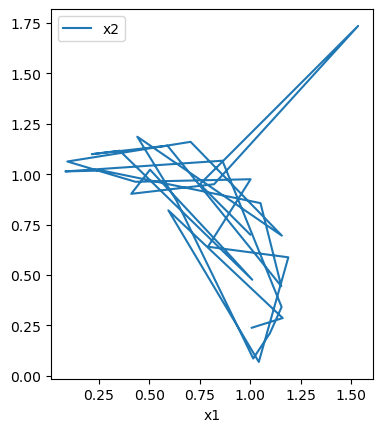

In [7]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")